## Import

In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torchdata
from torchvision.transforms import transforms
from torchinfo import summary

In [294]:
import netCDF4 as nc
import seaborn.colors.xkcd_rgb as c

## Classes

### Data Processor

In [390]:
class DataProcessor():
    def __init__(self, lu:str, input_varlist:list, proportion_list:list, jump_time:int=1):
        self.lu          = lu         # land type
        self.jump_time   = jump_time  # mapped adjustment time interval, defautl=1
        self.input_vlist = input_varlist    # input variables
        self.propo_list  = proportion_list  # train/(val)/test proportion

        self.day_num     = 2
        self.oneday_ts   = 721
        self.oneday_ts_jt= self.oneday_ts-self.jump_time   # one day time step considering jump time
        self.total_ts    = self.oneday_ts*self.day_num     # total time step
        self.total_ts_jt = self.oneday_ts_jt*self.day_num  # total time step considering jump time

        self.subset_idx  = self._Split_index()

    # Level 1 (universal)
    def _Split_index(self):
        """
        Split index (total time steps) by given proportions.
        !!Specifically (considering PBL diurnal properties)!!
        The proportion should be equally applied to (per day):
        Group1 (Daytime): (100-jt)~(400-jt); 
        Group2 (Nighttime): 0~(99-jt) & (401-jt)~(720-jt)
        """
        # Indices for Group1 (Day) and Group2 (Night)
        day_idx, night_idx = [], []
        for i in range(int(self.day_num)):
            day_idx.extend(range((100-self.jump_time)+(self.oneday_ts_jt*i), 
                                 (400-self.jump_time+1)+(self.oneday_ts_jt*i)))
            night_idx.extend(range(0+(self.oneday_ts_jt*i), 
                                   (100-self.jump_time)+(self.oneday_ts_jt*i)))
            night_idx.extend(range((400-self.jump_time+1)+(self.oneday_ts_jt*i), 
                                   self.oneday_ts_jt+(self.oneday_ts_jt*i)))
        day_idx, night_idx = np.array(day_idx), np.array(night_idx)
        # Shuffle indices for randomness
        np.random.shuffle(day_idx)
        np.random.shuffle(night_idx)
        # Split the day group and night group indices
        day_split   = np.split(day_idx, np.cumsum((np.array(self.propo_list)*day_idx.shape[0])[:-1]).astype(int))
        night_split = np.split(night_idx, np.cumsum((np.array(self.propo_list)*night_idx.shape[0])[:-1]).astype(int))
        subset_idx  = []
        for i in range(len(day_split)):
            combined_splits = np.concatenate([day_split[i], night_split[i]])
            np.random.shuffle(combined_splits)
            subset_idx.append(combined_splits)
        return tuple(subset_idx)
        
    def Get_torch_obj(self, dataset_type:str):
        """
        Convert numpy arrays into torch objects, currently accepted type: input/target
        """
        npset = eval(f"self._Create{dataset_type.title()}Npy()")
        return torch.from_numpy(npset).float()

    def Get_subset_data(self, data):
        """
        Split given data by self.subset_idx
        """
        subset_data = []
        for i in range(len(self.subset_idx)):
            subset_data.append(data[self.subset_idx[i], ...])
        return tuple(subset_data)   

    # Level 2 (depends on data)
    def _CreateInputNpy(self):
        """
        Create input data as a numpy object, later passed on to create a torch object.
        """
        for i, var in enumerate(self.input_vlist):
            # Load data from 2 soundings and combine into dim:(time, sample)
            var_s1   = self.Load_var(var, 's1', norm='MinMax')[self.jump_time:, ...]
            var_s2   = self.Load_var(var, 's2', norm='MinMax')[self.jump_time:, ...]
            var_comb = np.concatenate((var_s1, var_s2), axis=0)
            # Combine diff. vars
            if i < 1:
                var_inp = var_comb[:, np.newaxis, :]  # (time_step, var, level)
            else:
                var_inp = np.concatenate((var_inp, var_comb[:, np.newaxis, :]), axis=1)
        return var_inp

    def _CreateTargetNpy(self):
        """
        Create target data as a numpy object, later passed on to create a torch object.
        Current target: theta(t+jump_time)-theta(t)
        """
        th_s1, th_s2 = self.Load_var(sounding='s1', var='th'), self.Load_var(sounding='s2', var='th')
        # th_s1_diff   = self.Normalize_profs(th_s1[self.jump_time:, :]-th_s1[:-self.jump_time, :], 'MinMax')
        # th_s2_diff   = self.Normalize_profs(th_s2[self.jump_time:, :]-th_s2[:-self.jump_time, :], 'MinMax')
        th_s1_diff   = th_s1[self.jump_time:, :]-th_s1[:-self.jump_time, :]
        th_s2_diff   = th_s2[self.jump_time:, :]-th_s2[:-self.jump_time, :]
        th_diff      = np.concatenate((th_s1_diff, th_s2_diff), axis=0)
        th_diff_norm, self.th_diff_max, self.th_diff_min = self.Normalize_sets(th_diff, method='MinMax', return_scaler=True)
        return th_diff_norm
            
        
    def Load_var(self, var:str, sounding:str=False, norm:str=False):
        """
        Load variable data from specifc sounding.
        Normalization now supports minmax per dataset.
        """
        if sounding:
            ncsd  = nc.Dataset(f"/home/ch995334/2024ClDyn/lu_profs/{self.lu}_{sounding}.nc")
            value = ncsd.variables[var][:].data
        else:
            ncs1  = nc.Dataset(f"/home/ch995334/2024ClDyn/lu_profs/{self.lu}_s1.nc")
            ncs2  = nc.Dataset(f"/home/ch995334/2024ClDyn/lu_profs/{self.lu}_s2.nc")
            value1, value2 = ncs1.variables[var][:-self.jump_time, ...].data, ncs2.variables[var][:-self.jump_time, ...].data
            value = np.concatenate((value1, value2), axis=0)

        if norm == 'MinMax':
            # value_norm = self.Normalize_profs(value, method=norm)
            value_norm = self.Normalize_sets(value, method=norm)
            return value_norm
        else:
            return value
            

    # def Normalize_profs(self, prof_data:np.ndarray, method:str):
    #     if method=='MinMax':
    #         prof_max = np.nanmax(prof_data, axis=1) # (time, )
    #         prof_min = np.nanmin(prof_data, axis=1) # (time, )
    #         value_norm = (prof_data-np.repeat(prof_min[:, np.newaxis], repeats=prof_data.shape[1], axis=1))/ \
    #                      (np.repeat((prof_max-prof_min)[:, np.newaxis], repeats=prof_data.shape[1], axis=1))
    #         return value_norm
    #     else:
    #         print("Warning: Unsupported normalization method.")

    def Normalize_sets(self, prof_data:np.ndarray, method:str, return_scaler:bool=False):
        if method=='MinMax':
            set_max    = np.nanmax(prof_data)
            set_min    = np.nanmin(prof_data)
            value_norm = (prof_data-set_min)/(set_max-set_min)
            # return value_norm, set_max, set_min if return_scaler else value_norm
            if return_scaler:
                return value_norm, set_max, set_min
            else:
                return value_norm
        else:
            print("Warning: Unsupported normalization method.")
        

### Data Examinator

#### Data Storage

In [289]:
class DataStorage():
    def __init__(self, data_dict, train_loss, val_loss, prediction):
        self.data_dict  = data_dict
        self.train_loss = train_loss
        self.val_loss   = val_loss
        self.prediction = prediction

#### Examination/Analyses Functions

In [308]:
def cal_patt_corr(array1:np.ndarray, array2:np.ndarray):
    if array1.shape[0] < 2:
        correlation_matrix = np.corrcoef(array1, array2)
        coef = correlation_matrix[0, 1]
    else:
        coef = []
        for i in range(array1.shape[0]):
            correlation_matrix = np.corrcoef(array1[i, :], array2[i, :])
            coef.append(correlation_matrix[0, 1])
        coef = np.array(coef)
    return coef

In [358]:
def Plot_lu_metrics_box(lu_metrics_dict:dict, figpath:str=False):
    """
    lu_metrics_dict should be a dictionary storing the same metrics from different landtypes.
    """
    # Get the median of all landtype medians
    # all_medians = []
    # for patt_corr in lu_metrics_dict.values():
    #     all_medians.append(np.median(patt_corr))
    # all_medians = np.array(all_medians)
    # median_lu   = np.median(all_medians)
    
    # Get the median of all landtype mins
    all_Q1 = []
    for patt_corr in lu_metrics_dict.values():
        all_Q1.append(np.percentile(patt_corr, 25))
    all_Q1 = np.array(all_Q1)
    median_lu   = np.median(all_Q1)
    # Landtypes
    lu_list = list(lu_metrics_dict.keys())   # ['OU', 'GU', 'PU', 'EU', 'OG', 'OE', 'OP', 'PG', 'GE', 'PE']
    # Box settings
    boxprops_top5 = dict(linestyle='-', linewidth=4, color=c['cherry'])
    boxprops_low5 = dict(linestyle='-', linewidth=4, color=c['azure'])
    medianprops   = dict(linestyle='-', linewidth=4, color='k')
    # Plot 
    fig, ax = plt.subplots(figsize=(12, 6))
    for i, lu in enumerate(lu_list):
        if all_Q1[i]>=median_lu:
            ax.boxplot(lu_metrics_dict[lu.lower()], positions=np.array([len(lu_list)-i]), tick_labels=[lu], 
                       showfliers=False, widths=.4, boxprops=boxprops_top5, medianprops=medianprops)
        else:
            ax.boxplot(lu_metrics_dict[lu.lower()], positions=np.array([len(lu_list)-i]), tick_labels=[lu], 
                       showfliers=False, widths=.4, boxprops=boxprops_low5, medianprops=medianprops)
    ax.grid(linestyle=':', linewidth=0.5, color='grey')
    ax.set_ylim([0.85, 1])
    ax.set_yticks(np.arange(0.86, 1.01, 0.02))
    ax.set_yticklabels([f"{i:4.2f}" for i in np.arange(0.86, 1.01, 0.02)], fontsize=14)
    ax.set_xticklabels([f"{lu.upper()}" for lu in lu_list], fontsize=14)
    ax.set_title(r'$\Delta \theta$ Profile Correlation Distribution', fontweight='bold', fontsize=18)
    if figpath:
        plt.savefig(f'/home/ch995334/2024ClDyn/Figure/Final/box_{figpath}.png', bbox_inches='tight', facecolor='w', dpi=400)
    else:
        plt.show()

In [ ]:
def hindcast(model, norm_x:torch.Tensor, norm_y:torch.Tensor, unnorm_theta:torch.Tensor, 
             th_diff_min, th_diff_max, predict_tsteps:int):
    """
    norm_x: Normalized input variables, to get the predicted delta theta
    norm_y: Normalized target (just to create valid dataloader)
    unnorm_theta: Unnormalized theta, to create input for the next timestep & serve as the next calibration
    th_diff_min: Scaler
    th_diff_max: Scaler
    predict_tsteps: How many time steps should the nn model predict
    """
    # Checking
    if norm_x.shape[1] > 1:
        raise logging.warning("Default treats the input variable on index 0 as theta.")
    if th_diff_min >= th_diff_max:
        raise ValueError("th_diff_min >= th_diff_max")
    # Create dataloader
    full_dataset = torchdata.TensorDataset(norm_x, norm_y)
    full_loader  = torchdata.DataLoader(full_dataset, batch_size=1)
    # Run through nn model predictions
    model.eval()
    for big_t in range(0, norm_x.shape[0], predict_tsteps):   # chunks of calibration - prediction*n
        loader_ts   = full_loader[big_t, ...]                 # initiate/calibration step
        loader_loop = loader_ts.copy()
        for small_t in range(predict_tsteps):                 # prediction*n
            th_diff_pred = predict(model, loader_loop)
            th_diff_real = th_diff_pred*(th_diff_max-th_diff_min)+th_diff_min
            rollout_th   = unnorm_theta[]

### NN Model

#### Define NN Model

In [280]:
class CNN1D(nn.Module):
    def __init__(self, input_var_num:int):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_var_num, out_channels=16, kernel_size=3, stride=1) # no padding, -2
        # self.pool1 = nn.MaxPool1d(kernel_size=2, stride=1)  # -1
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1)  # no padding, -2
        # self.pool2 = nn.MaxPool1d(kernel_size=2, stride=1)  # -1
        self.fc1 = nn.Linear(32*46, 64)  # 46 = 50-2-2
        # self.fc1 = nn.Linear(32*44, 64)  # 44 = 50-2-2-2
        self.fc2 = nn.Linear(64, 50)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        # x = self.pool1(x)
        x = self.relu(self.conv2(x))
        # x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN1D(input_var_num=1)
summary(model, input_size=(32,1,50), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [32, 50]                  --
├─Conv1d: 1-1                            [32, 16, 48]              64
├─ReLU: 1-2                              [32, 16, 48]              --
├─Conv1d: 1-3                            [32, 32, 46]              1,568
├─ReLU: 1-4                              [32, 32, 46]              --
├─Flatten: 1-5                           [32, 1472]                --
├─Linear: 1-6                            [32, 64]                  94,272
├─ReLU: 1-7                              [32, 64]                  --
├─Linear: 1-8                            [32, 50]                  3,250
Total params: 99,154
Trainable params: 99,154
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.53
Input size (MB): 0.01
Forward/backward pass size (MB): 0.60
Params size (MB): 0.40
Estimated Total Size (MB): 1.01

#### Define Training

In [255]:
def train(input_varlist, train_loader, val_loader, epochs:int):
    # Assign device
    device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("========In train()========")
    print("Device:", device)
    print("==========================")
    # Model settings
    model     = CNN1D(input_var_num=len(input_varlist)).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    train_loss_log, val_loss_log = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss_log.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        val_loss_log.append(val_loss/len(val_loader))
        # Print loss on screen
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
    return model, train_loss_log, val_loss_log

#### Define Predict

In [246]:
def predict(model, test_loader):
    # Assign device
    device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("========In train()========")
    print("Device:", device)
    print("==========================")
    # Get prediction
    model.eval()
    counter = 0
    with torch.no_grad():                     # disable gradient descend
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
            pred            = model(inputs)
            if counter < 1:
                model_pred = pred.detach().cpu().numpy()
                print(model_pred.shape)
            else:
                model_pred = np.concatenate((model_pred, pred.detach().cpu().numpy()), axis=0)
            counter += 1
    return model_pred

#### Save Model

In [407]:
def save_model(model, savepath:str):
    model.eval()
    torch.save(model.state_dict(), f"{savepath}_state.pt")

#### Load Saved Model

In [408]:
def load_model(model_instance, savepath:str):
    """
    `model_instance` should be the exact same in structure with what this function is loading.
    """
    model_instance.load_state_dict(torch.load(f"{savepath}_state.pt", weights_only=True))
    return model_instance

## Execution

In [291]:
def main(lu:str, input_varlist:list, epochs:int):
    print("====Experiment Settings===")
    print("Land type:", lu)
    print("Input vars:", input_varlist)
    print("==========================")
    # Fix all seeds
    seed = 42
    torch.manual_seed(seed)  # for CPU-based random operation in PyTorch
    np.random.seed(seed)     # for numpy random functions (if any)
    torch.cuda.manual_seed(seed)      # for GPU-based random operation (single GPU)
    print("===Testing random seeds===")
    print("Current seed:", seed)
    print("Random value from torch:", torch.rand(1).item(), " -> should be 0.8822692632675171 for seed=42")
    print("Random value from numpy:", np.random.rand(1)[0], " -> should be 0.3745401188473625 for seed=42")
    print("==========================")
    # Generate data
    ## For ML training
    train_size, test_size = 0.8, 0.2
    dataprocessor         = DataProcessor(lu, input_varlist, proportion_list=[train_size, test_size])
    train_idx, test_idx   = dataprocessor.subset_idx
    input_obj             = dataprocessor.Get_torch_obj('input')   # input x (torch.Tensor)
    target_obj            = dataprocessor.Get_torch_obj('target')  # target y (torch.Tensor)
    print(input_obj.shape, target_obj.shape)
    x_train, x_test       = dataprocessor.Get_subset_data(input_obj)   # var state profiles
    y_train, y_test       = dataprocessor.Get_subset_data(target_obj)  # theta adjustment profiles
    train_dataset         = torchdata.TensorDataset(x_train, y_train)
    test_dataset          = torchdata.TensorDataset(x_test, y_test)
    train_loader = torchdata.DataLoader(train_dataset, batch_size=32)  # already shuffled in DataPreprocessor
    test_loader  = torchdata.DataLoader(test_dataset, batch_size=1)
    
    ## For post-analyses
    th_diff_max           = dataprocessor.th_diff_max                  # only works after target data is computed \
    th_diff_min           = dataprocessor.th_diff_min                  # it's for scaling back theta adjustment
    theta_state           = dataprocessor.Load_var(var='th')           # theta state, two soundings, unnormalized
    th_train,th_test      = dataprocessor.Get_subset_data(theta_state)
    data_dict = {'x_train': x_train, 'x_test': x_test,
                 'y_train': y_train, 'y_test': y_test,
                 'th_diff_max': th_diff_max, 'th_diff_min': th_diff_min, 
                 'th_train': th_train, 'th_test': th_test}

    # Train model
    trained_model, train_loss, val_loss = train(input_varlist, 
                                                train_loader, test_loader, epochs=epochs) # use testing set as validation
    trained_model.eval()
    prediction = predict(trained_model, test_loader)
    data_storage = DataStorage(data_dict, train_loss, val_loss, prediction)
    return trained_model, data_storage

### All landtypes, only input theta

#### Train models and store outputs

In [299]:
lu_list = ['OU', 'GU', 'PU', 'EU', 'OG', 'OE', 'OP', 'PG', 'GE', 'PE']

In [ ]:
# ['OU', 'GU', 'PU', 'EU', 'OG', 'OE', 'OP', 'PG', 'GE', 'PE']
model1_ou, data_store1_ou = main(lu='ou', input_varlist=['th'], epochs=200)
model1_gu, data_store1_gu = main(lu='gu', input_varlist=['th'], epochs=200)
model1_pu, data_store1_pu = main(lu='pu', input_varlist=['th'], epochs=200)
model1_eu, data_store1_eu = main(lu='eu', input_varlist=['th'], epochs=200)
model1_og, data_store1_og = main(lu='og', input_varlist=['th'], epochs=200)
model1_oe, data_store1_oe = main(lu='oe', input_varlist=['th'], epochs=200)
model1_op, data_store1_op = main(lu='op', input_varlist=['th'], epochs=200)
model1_pg, data_store1_pg = main(lu='pg', input_varlist=['th'], epochs=200)
model1_ge, data_store1_ge = main(lu='ge', input_varlist=['th'], epochs=200)
model1_pe, data_store1_pe = main(lu='pe', input_varlist=['th'], epochs=200)

In [410]:
for lu in lu_list:
    model_to_be_saved = eval(f"model1_{lu.lower()}")
    save_model(model=model_to_be_saved, savepath=f"/home/ch995334/2024ClDyn/Model/cnn1/model1_{lu.lower()}")

#### Correlation distribution

In [324]:
dict1_patt_corr_lu = dict(zip([f"{i.lower()}" for i in lu_list], [[] for i in range(len(lu_list))]))
for i, LU in enumerate(lu_list):
    lu = LU.lower()
    data_store1_lu = eval(f"data_store1_{lu}")
    y_test, pred   = data_store1_lu.data_dict['y_test'], data_store1_lu.prediction
    dict1_patt_corr_lu[lu] = cal_patt_corr(y_test, pred)

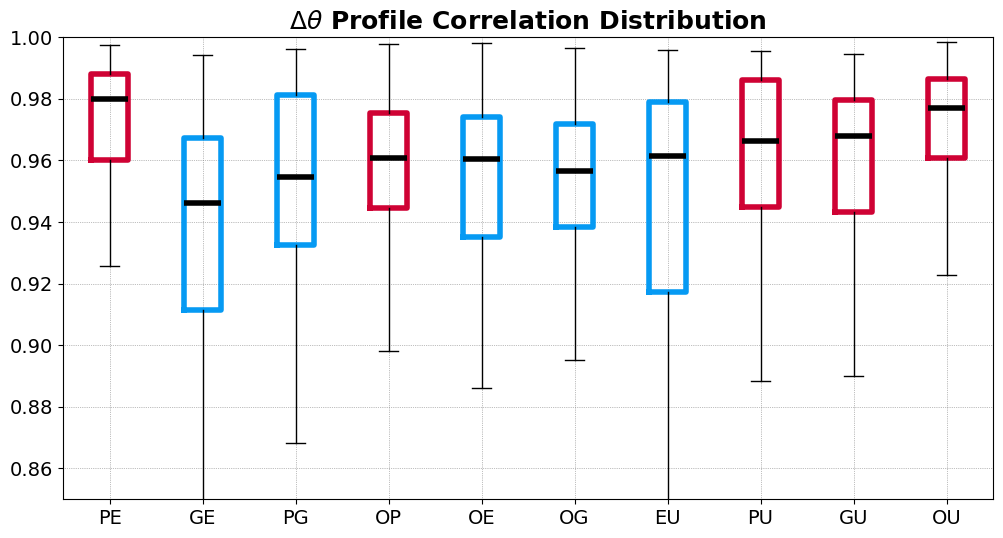

In [359]:
Plot_lu_metrics_box(dict1_patt_corr_lu, figpath='1var')

#### Hindcast

### All landtypes, input theta, wth, tke, enstrophy

#### Train models and store outputs

In [ ]:
# ['OU', 'GU', 'PU', 'EU', 'OG', 'OE', 'OP', 'PG', 'GE', 'PE']
model2_ou, data_store2_ou = main(lu='ou', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)
model2_gu, data_store2_gu = main(lu='gu', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)
model2_pu, data_store2_pu = main(lu='pu', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)
model2_eu, data_store2_eu = main(lu='eu', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)
model2_og, data_store2_og = main(lu='og', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)
model2_oe, data_store2_oe = main(lu='oe', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)
model2_op, data_store2_op = main(lu='op', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)
model2_pg, data_store2_pg = main(lu='pg', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)
model2_ge, data_store2_ge = main(lu='ge', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)
model2_pe, data_store2_pe = main(lu='pe', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)

In [334]:
dict2_patt_corr_lu = dict(zip([f"{i.lower()}" for i in lu_list], [[] for i in range(len(lu_list))]))
for i, LU in enumerate(lu_list):
    lu = LU.lower()
    data_store2_lu = eval(f"data_store2_{lu}")
    y_test, pred   = data_store2_lu.data_dict['y_test'], data_store2_lu.prediction
    dict2_patt_corr_lu[lu] = cal_patt_corr(y_test, pred)

In [411]:
for lu in lu_list:
    model_to_be_saved = eval(f"model2_{lu.lower()}")
    save_model(model=model_to_be_saved, savepath=f"/home/ch995334/2024ClDyn/Model/cnn1/model2_{lu.lower()}")

#### Correlation distribution

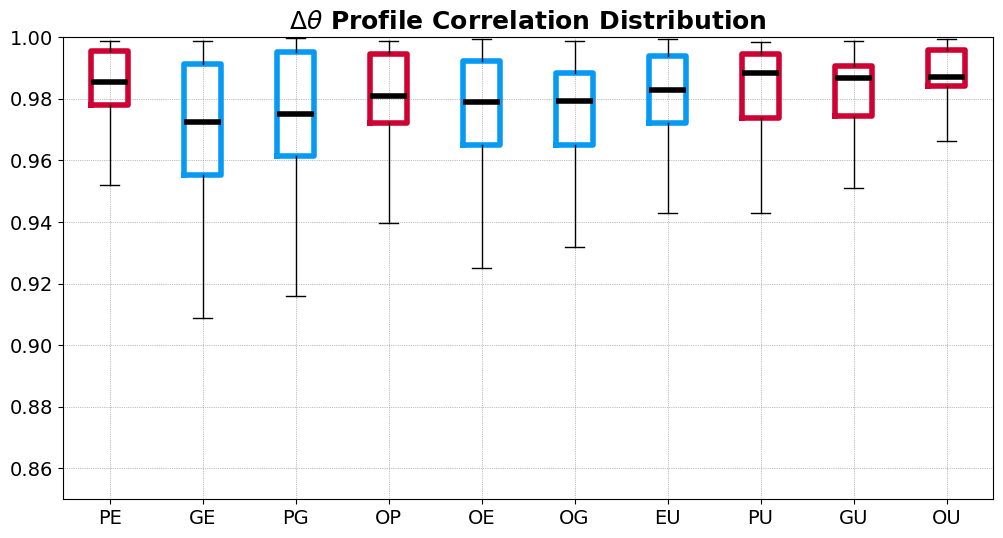

In [360]:
Plot_lu_metrics_box(dict2_patt_corr_lu, figpath='4var')

## Test

In [8]:
nctemp = nc.Dataset(f"/home/ch995334/2024ClDyn/lu_profs/oe_s1.nc")
nctemp.variables['wth'][:].data.shape

(721, 50)

In [13]:
np.ones((5, 2))-np.repeat(np.arange(5)[:, np.newaxis], repeats=2, axis=1)

array([[ 1.,  1.],
       [ 0.,  0.],
       [-1., -1.],
       [-2., -2.],
       [-3., -3.]])

In [58]:
tempDP = DataProcessor(lu='oe', input_varlist=['th'])

### Test in main()

#### Single input channel (theta)

In [ ]:
trained_model, data_examinator = main(lu='oe', input_varlist=['th', 'wth', 'tke', 'enstrophy'], epochs=200)

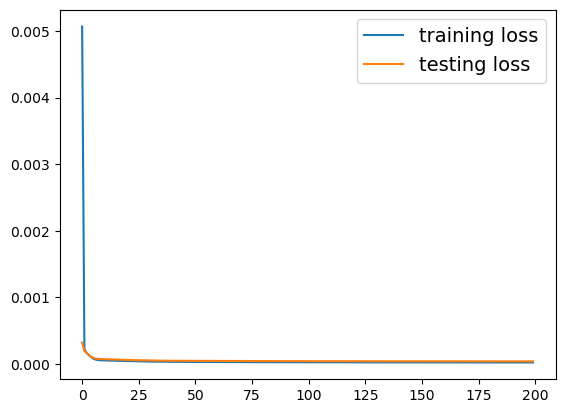

In [285]:
plt.plot(np.arange(200), data_examinator.train_loss, label='training loss')
plt.plot(np.arange(200), data_examinator.val_loss, label='testing loss')
plt.legend(fontsize=14)

Text(0.5, 1.0, 'model prediction from x_test')

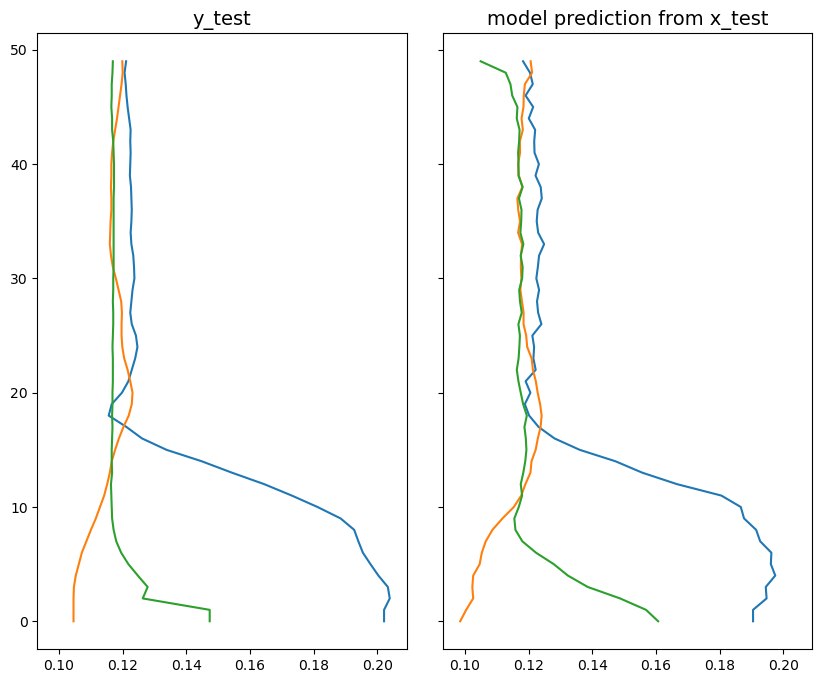

In [269]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_examinator.data_dict['y_test'][20, :], np.arange(50))
ax[0].plot(data_examinator.data_dict['y_test'][120, :], np.arange(50))
ax[0].plot(data_examinator.data_dict['y_test'][220, :], np.arange(50))
ax[0].set_title('y_test', fontsize=14)

ax[1].plot(data_examinator.prediction[20, :], np.arange(50))
ax[1].plot(data_examinator.prediction[120, :], np.arange(50))
ax[1].plot(data_examinator.prediction[220, :], np.arange(50))
ax[1].set_title('model prediction from x_test', fontsize=14)

Text(0.5, 1.0, 'model prediction from x_test')

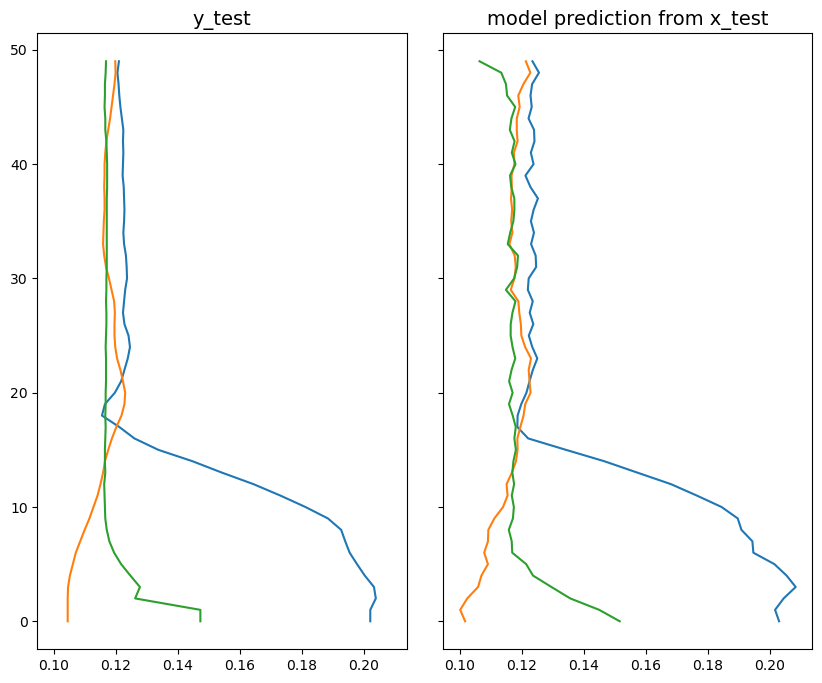

In [283]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_examinator.data_dict['y_test'][20, :], np.arange(50))
ax[0].plot(data_examinator.data_dict['y_test'][120, :], np.arange(50))
ax[0].plot(data_examinator.data_dict['y_test'][220, :], np.arange(50))
ax[0].set_title('y_test', fontsize=14)

ax[1].plot(data_examinator.prediction[20, :], np.arange(50))
ax[1].plot(data_examinator.prediction[120, :], np.arange(50))
ax[1].plot(data_examinator.prediction[220, :], np.arange(50))
ax[1].set_title('model prediction from x_test', fontsize=14)

Text(0.5, 1.0, 'model prediction from x_test')

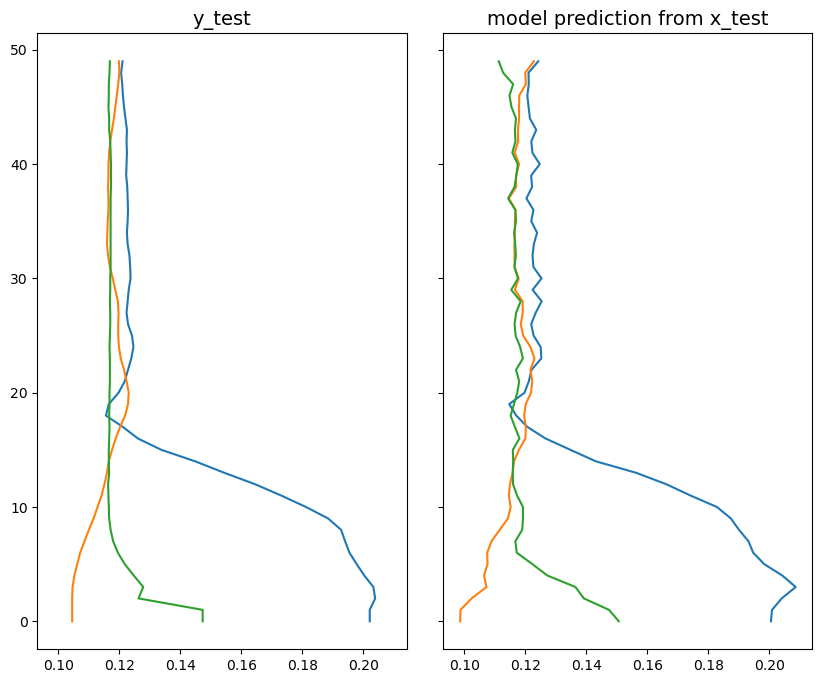

In [286]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_examinator.data_dict['y_test'][20, :], np.arange(50))
ax[0].plot(data_examinator.data_dict['y_test'][120, :], np.arange(50))
ax[0].plot(data_examinator.data_dict['y_test'][220, :], np.arange(50))
ax[0].set_title('y_test', fontsize=14)

ax[1].plot(data_examinator.prediction[20, :], np.arange(50))
ax[1].plot(data_examinator.prediction[120, :], np.arange(50))
ax[1].plot(data_examinator.prediction[220, :], np.arange(50))
ax[1].set_title('model prediction from x_test', fontsize=14)

Text(0.5, 1.0, 'model prediction from x_test')

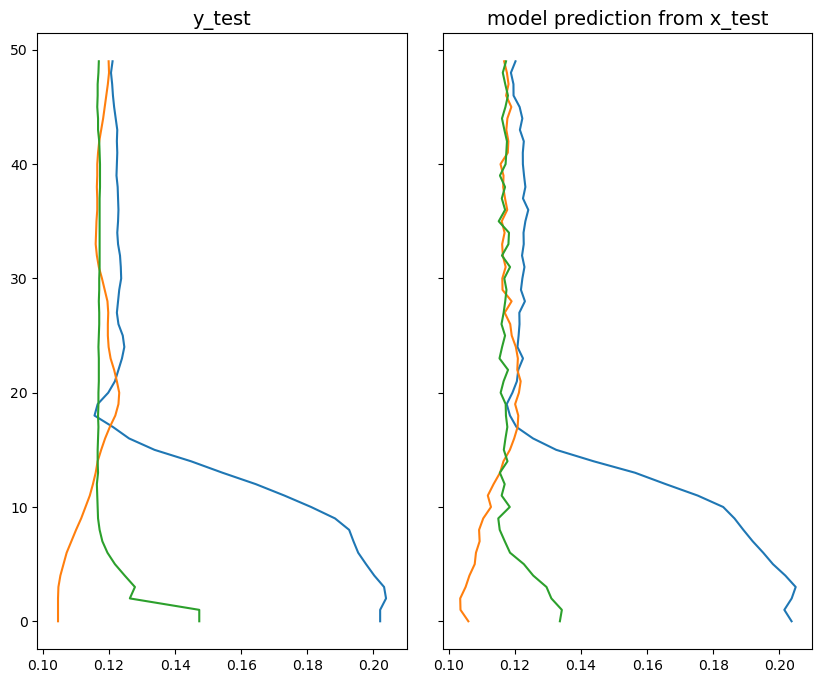

In [288]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_examinator.data_dict['y_test'][20, :], np.arange(50))
ax[0].plot(data_examinator.data_dict['y_test'][120, :], np.arange(50))
ax[0].plot(data_examinator.data_dict['y_test'][220, :], np.arange(50))
ax[0].set_title('y_test', fontsize=14)

ax[1].plot(data_examinator.prediction[20, :], np.arange(50))
ax[1].plot(data_examinator.prediction[120, :], np.arange(50))
ax[1].plot(data_examinator.prediction[220, :], np.arange(50))
ax[1].set_title('model prediction from x_test', fontsize=14)

Text(0.5, 1.0, 'model prediction from x_test')

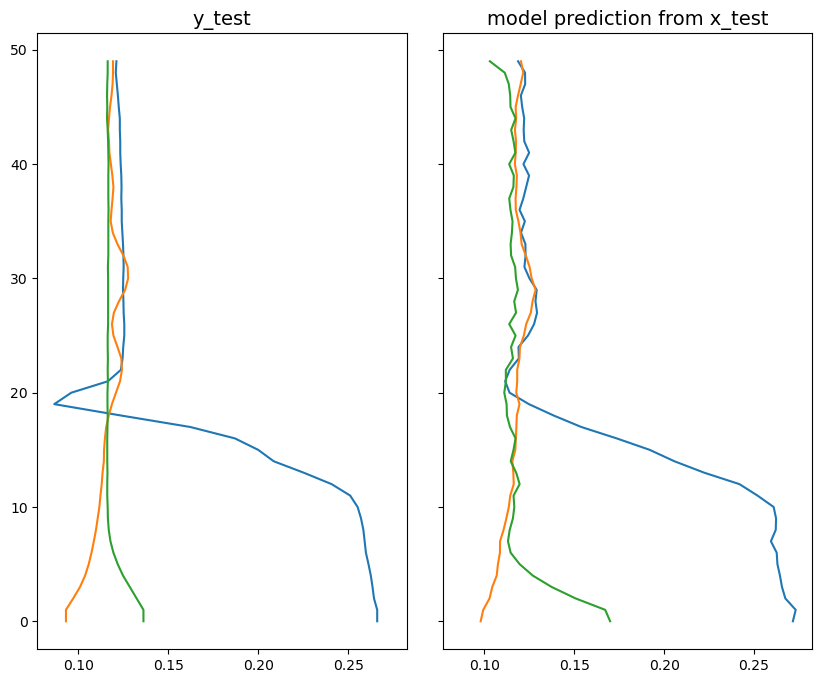

In [295]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_store1_pu.data_dict['y_test'][20, :], np.arange(50))
ax[0].plot(data_store1_pu.data_dict['y_test'][120, :], np.arange(50))
ax[0].plot(data_store1_pu.data_dict['y_test'][220, :], np.arange(50))
ax[0].set_title('y_test', fontsize=14)

ax[1].plot(data_store1_pu.prediction[20, :], np.arange(50))
ax[1].plot(data_store1_pu.prediction[120, :], np.arange(50))
ax[1].plot(data_store1_pu.prediction[220, :], np.arange(50))
ax[1].set_title('model prediction from x_test', fontsize=14)

Text(0.5, 1.0, 'model prediction from x_test')

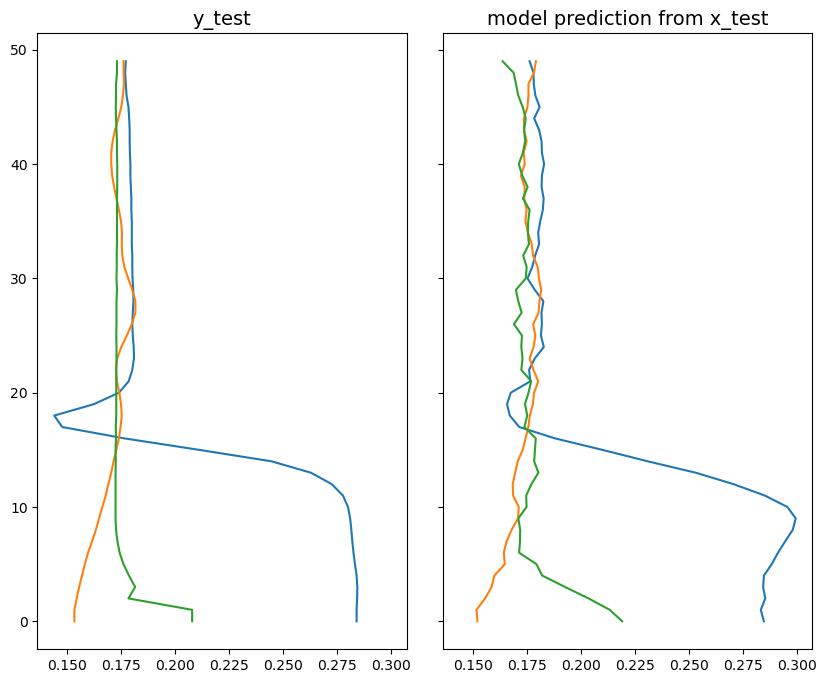

In [296]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_store1_ge.data_dict['y_test'][20, :], np.arange(50))
ax[0].plot(data_store1_ge.data_dict['y_test'][120, :], np.arange(50))
ax[0].plot(data_store1_ge.data_dict['y_test'][220, :], np.arange(50))
ax[0].set_title('y_test', fontsize=14)

ax[1].plot(data_store1_ge.prediction[20, :], np.arange(50))
ax[1].plot(data_store1_ge.prediction[120, :], np.arange(50))
ax[1].plot(data_store1_ge.prediction[220, :], np.arange(50))
ax[1].set_title('model prediction from x_test', fontsize=14)

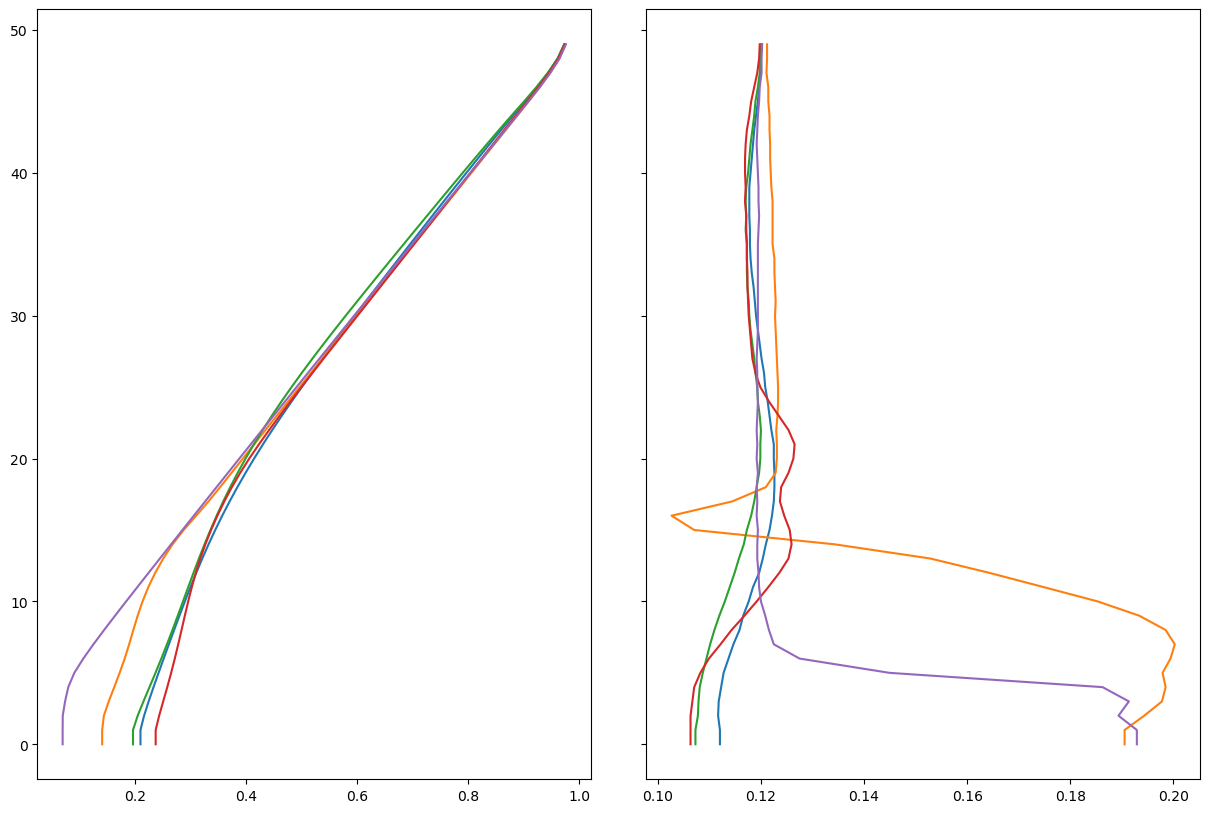

In [174]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 10), gridspec_kw={'wspace':0.1})
ax[0].plot(data_dict['x_train'][20, :], np.arange(50))
ax[0].plot(data_dict['x_train'][120, :], np.arange(50))
ax[0].plot(data_dict['x_train'][220, :], np.arange(50))
ax[0].plot(data_dict['x_train'][320, :], np.arange(50))
ax[0].plot(data_dict['x_train'][420, :], np.arange(50))

ax[1].plot(data_dict['y_train'][20, :], np.arange(50))
ax[1].plot(data_dict['y_train'][120, :], np.arange(50))
ax[1].plot(data_dict['y_train'][220, :], np.arange(50))
ax[1].plot(data_dict['y_train'][320, :], np.arange(50))
ax[1].plot(data_dict['y_train'][420, :], np.arange(50))

### Test after Training

In [362]:
sort_temp = np.argsort(dict1_patt_corr_lu['eu'])

In [374]:
np.arange(0, 2, 0.4)

array([0. , 0.4, 0.8, 1.2, 1.6])

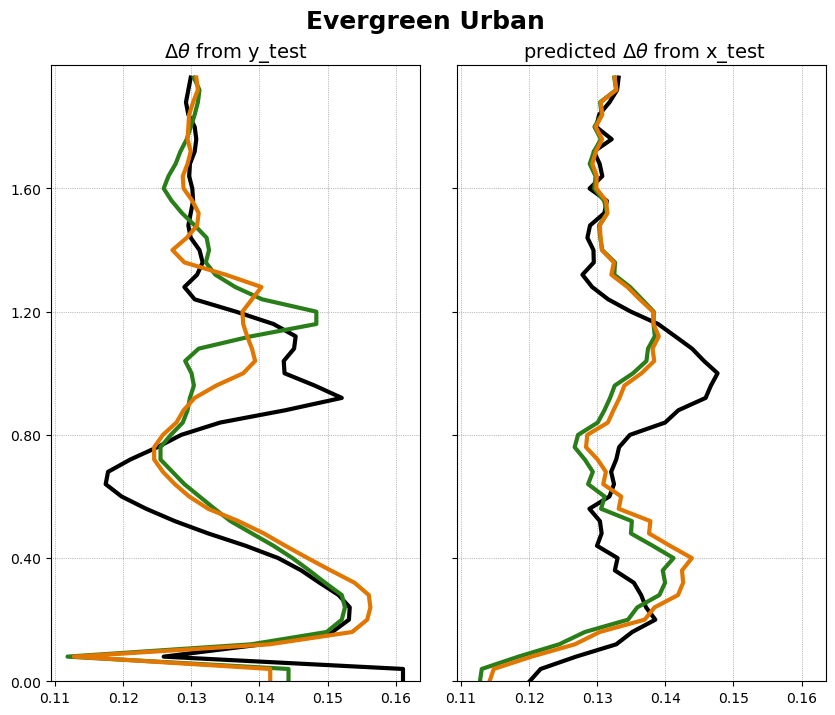

In [388]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_store1_eu.data_dict['y_test'][sort_temp[1], :], np.arange(50), color='k', linewidth=3)
ax[0].plot(data_store1_eu.data_dict['y_test'][sort_temp[3], :], np.arange(50), color=c['tree green'], linewidth=3)
ax[0].plot(data_store1_eu.data_dict['y_test'][sort_temp[5], :], np.arange(50), color=c['pumpkin'], linewidth=3)
ax[0].set_title(r'$\Delta \theta$ from y_test', fontsize=14)

ax[1].plot(data_store1_eu.prediction[sort_temp[1], :], np.arange(50), color='k', linewidth=3)
ax[1].plot(data_store1_eu.prediction[sort_temp[3], :], np.arange(50), color=c['tree green'], linewidth=3)
ax[1].plot(data_store1_eu.prediction[sort_temp[5], :], np.arange(50), color=c['pumpkin'], linewidth=3)
ax[1].set_title(r' predicted $\Delta \theta$ from x_test', fontsize=14)

ax[0].grid(linestyle=':', linewidth=0.5, color='grey')
ax[1].grid(linestyle=':', linewidth=0.5, color='grey')
ax[0].set_ylim(0, 50)
ax[0].set_yticks(np.arange(0, 50, 10))
ax[0].set_yticklabels([f"{i:4.2f}" for i in np.arange(0, 2, 0.4)])
fig.suptitle(x=0.5, y=0.95, t='Evergreen Urban', fontweight='bold', fontsize=18)
plt.savefig("/home/ch995334/2024ClDyn/Figure/Final/y_compar_worst_eu.png", 
            bbox_inches='tight', facecolor='w', dpi=400)

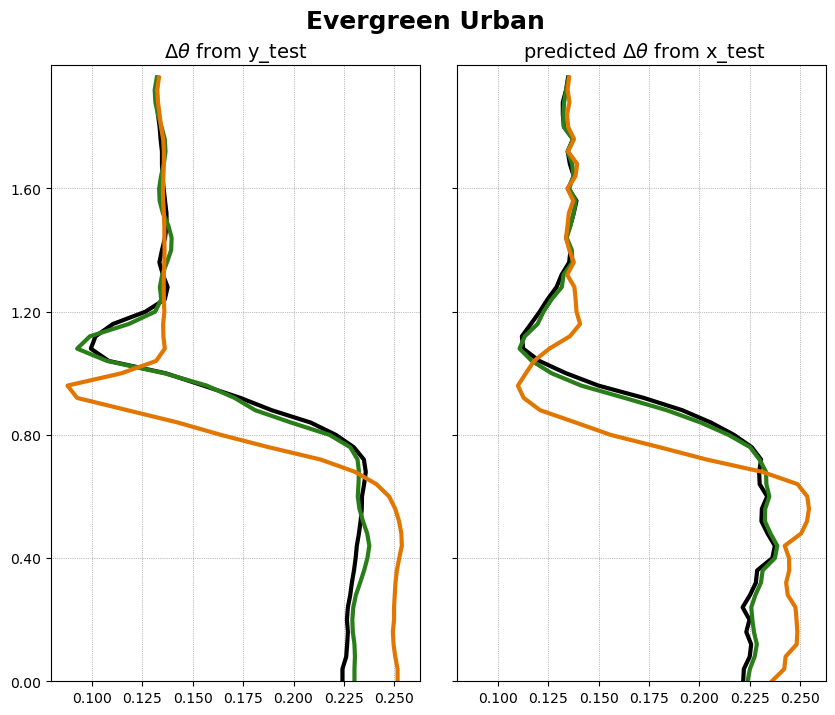

In [389]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_store1_eu.data_dict['y_test'][sort_temp[-1], :], np.arange(50), color='k', linewidth=3)
ax[0].plot(data_store1_eu.data_dict['y_test'][sort_temp[-3], :], np.arange(50), color=c['tree green'], linewidth=3)
ax[0].plot(data_store1_eu.data_dict['y_test'][sort_temp[-5], :], np.arange(50), color=c['pumpkin'], linewidth=3)
ax[0].set_title(r'$\Delta \theta$ from y_test', fontsize=14)

ax[1].plot(data_store1_eu.prediction[sort_temp[-1], :], np.arange(50), color='k', linewidth=3)
ax[1].plot(data_store1_eu.prediction[sort_temp[-3], :], np.arange(50), color=c['tree green'], linewidth=3)
ax[1].plot(data_store1_eu.prediction[sort_temp[-5], :], np.arange(50), color=c['pumpkin'], linewidth=3)
ax[1].set_title(r' predicted $\Delta \theta$ from x_test', fontsize=14)

ax[0].grid(linestyle=':', linewidth=0.5, color='grey')
ax[1].grid(linestyle=':', linewidth=0.5, color='grey')
ax[0].set_ylim(0, 50)
ax[0].set_yticks(np.arange(0, 50, 10))
ax[0].set_yticklabels([f"{i:4.2f}" for i in np.arange(0, 2, 0.4)])
fig.suptitle(x=0.5, y=0.95, t='Evergreen Urban', fontweight='bold', fontsize=18)
plt.savefig("/home/ch995334/2024ClDyn/Figure/Final/y_compar_best_eu.png", 
            bbox_inches='tight', facecolor='w', dpi=400)

Text(0.5, 1.0, 'model prediction from x_test')

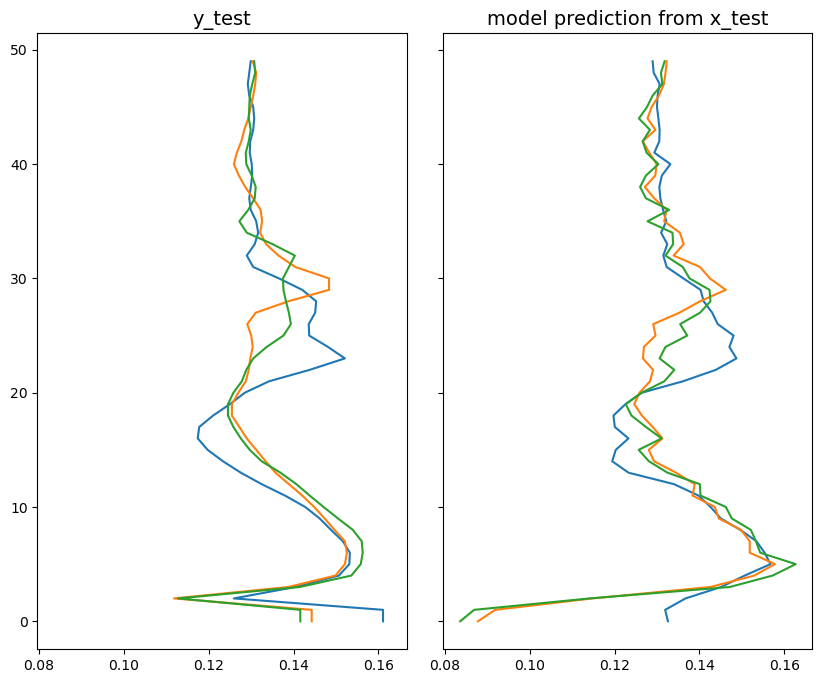

In [365]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_store2_eu.data_dict['y_test'][sort_temp[1], :], np.arange(50))
ax[0].plot(data_store2_eu.data_dict['y_test'][sort_temp[3], :], np.arange(50))
ax[0].plot(data_store2_eu.data_dict['y_test'][sort_temp[5], :], np.arange(50))
ax[0].set_title('y_test', fontsize=14)

ax[1].plot(data_store2_eu.prediction[sort_temp[1], :], np.arange(50))
ax[1].plot(data_store2_eu.prediction[sort_temp[3], :], np.arange(50))
ax[1].plot(data_store2_eu.prediction[sort_temp[5], :], np.arange(50))
ax[1].set_title('model prediction from x_test', fontsize=14)

Text(0.5, 1.0, 'model prediction from x_test')

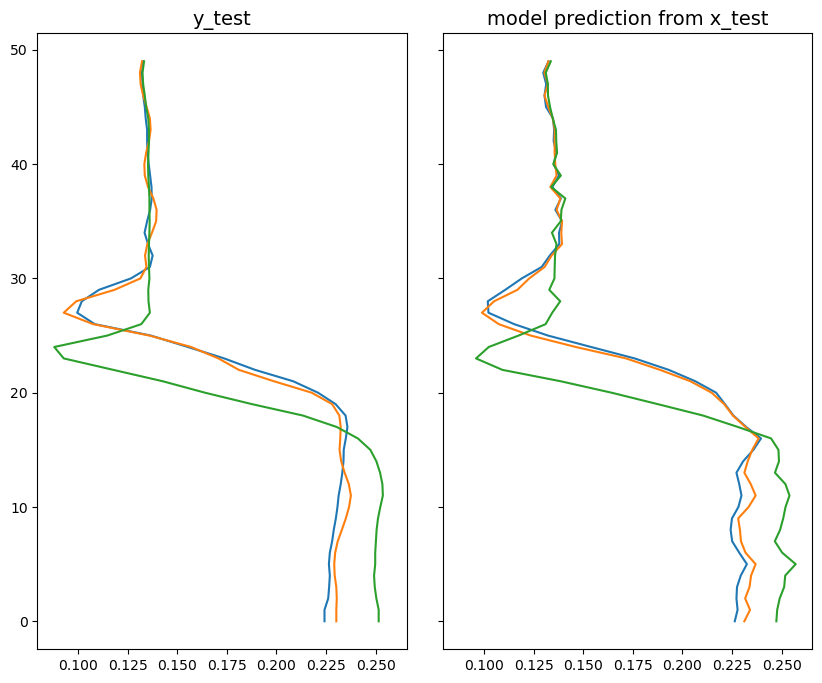

In [366]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 8), gridspec_kw={'wspace':0.1})
ax[0].plot(data_store2_eu.data_dict['y_test'][sort_temp[-1], :], np.arange(50))
ax[0].plot(data_store2_eu.data_dict['y_test'][sort_temp[-3], :], np.arange(50))
ax[0].plot(data_store2_eu.data_dict['y_test'][sort_temp[-5], :], np.arange(50))
ax[0].set_title('y_test', fontsize=14)

ax[1].plot(data_store2_eu.prediction[sort_temp[-1], :], np.arange(50))
ax[1].plot(data_store2_eu.prediction[sort_temp[-3], :], np.arange(50))
ax[1].plot(data_store2_eu.prediction[sort_temp[-5], :], np.arange(50))
ax[1].set_title('model prediction from x_test', fontsize=14)

### Test saving models

In [399]:
torch.save(model1_eu.state_dict(), '/home/ch995334/2024ClDyn/Model/cnn1/model1_eu_state.pt')

In [392]:
model1_eu

CNN1D(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=1472, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [405]:
model1_eu_load = CNN1D(input_var_num=1)
model1_eu_load.load_state_dict(torch.load('/home/ch995334/2024ClDyn/Model/cnn1/model1_eu_state.pt', weights_only=True))

<All keys matched successfully>

In [406]:
model1_eu_load

CNN1D(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=1472, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

### Normalize by profile

In [37]:
th_temp = tempDP.Load_var(var='th', sounding='s1', norm='MinMax')

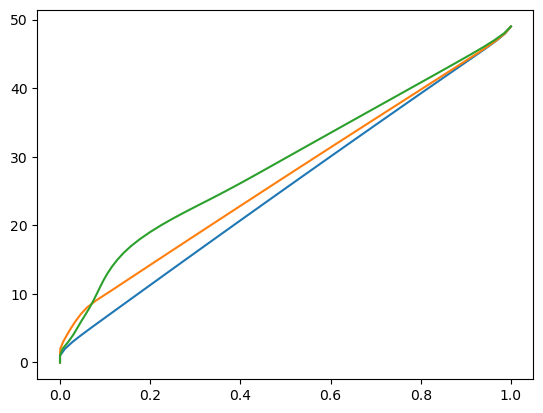

In [38]:
plt.plot(th_temp[20, :], np.arange(50))
plt.plot(th_temp[120, :], np.arange(50))
plt.plot(th_temp[220, :], np.arange(50))

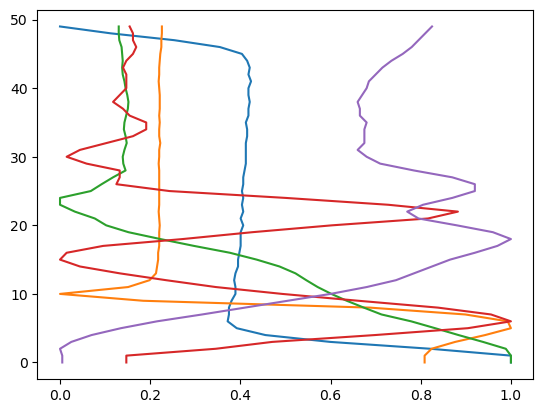

In [51]:
target_temp = tempDP.Get_torch_obj('target')
plt.plot(target_temp[20, :], np.arange(50))
plt.plot(target_temp[120, :], np.arange(50))
plt.plot(target_temp[220, :], np.arange(50))
plt.plot(target_temp[320, :], np.arange(50))
plt.plot(target_temp[420, :], np.arange(50))

### Normalize by set

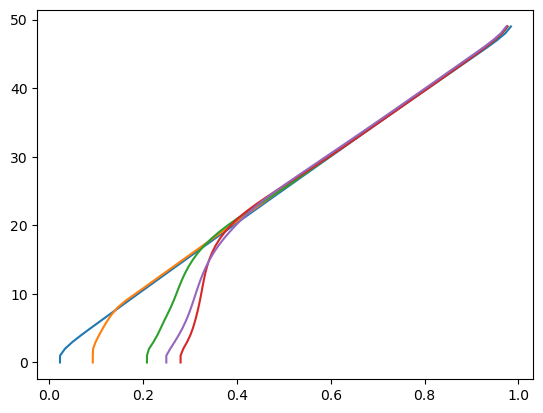

In [55]:
th_temp3 = tempDP.Load_var(var='th', sounding='s1', norm='MinMax')
plt.plot(th_temp3[20, :], np.arange(50))
plt.plot(th_temp3[120, :], np.arange(50))
plt.plot(th_temp3[220, :], np.arange(50))
plt.plot(th_temp3[320, :], np.arange(50))
plt.plot(th_temp3[420, :], np.arange(50))

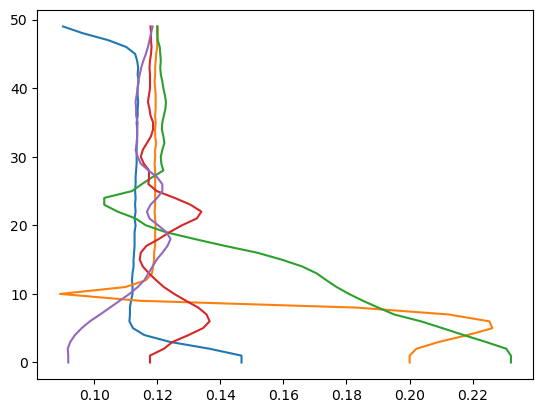

In [59]:
target_temp3 = tempDP.Get_torch_obj('target')
plt.plot(target_temp3[20, :], np.arange(50))
plt.plot(target_temp3[120, :], np.arange(50))
plt.plot(target_temp3[220, :], np.arange(50))
plt.plot(target_temp3[320, :], np.arange(50))
plt.plot(target_temp3[420, :], np.arange(50))

In [64]:
target_temp3[2:5, ...].shape

torch.Size([3, 50])

### Unnormalized

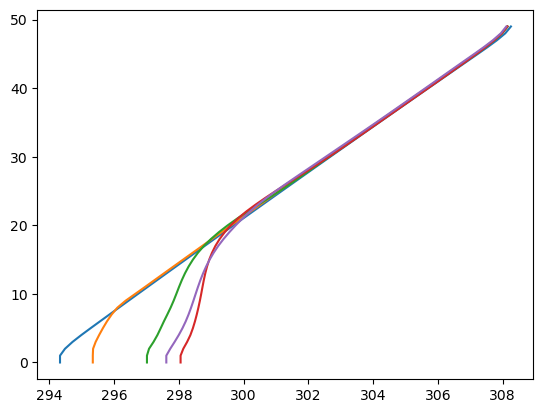

In [50]:
th_temp2 = tempDP.Load_var(var='th', sounding='s1')
plt.plot(th_temp2[20, :], np.arange(50))
plt.plot(th_temp2[120, :], np.arange(50))
plt.plot(th_temp2[220, :], np.arange(50))
plt.plot(th_temp2[320, :], np.arange(50))
plt.plot(th_temp2[420, :], np.arange(50))

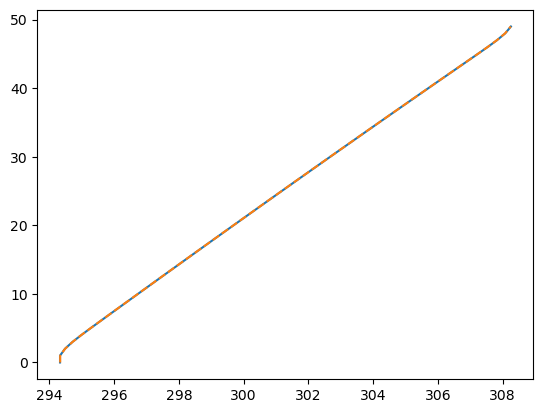

In [45]:
plt.plot(th_temp2[20, :], np.arange(50), '-')
plt.plot(th_temp2[21, :], np.arange(50), '--')

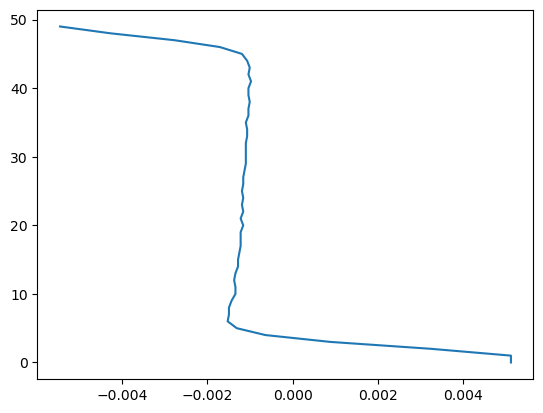

In [47]:
plt.plot(th_temp2[21, :]-th_temp2[20, :], np.arange(50))